In [1]:
cd ..

/media/sanjyot/DATA/UMich google drive/Academics/Fall 2020/Data Security and Privacy - CIS 545/project/EvaluatingDPML


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
import numpy as np

from attack import load_data, train_target_model, yeom_membership_inference
from sklearn.metrics import roc_curve, auc, accuracy_score
from utilities import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [25]:
import pandas as pd

In [5]:
DATA_PATH = 'data/'
data_name = 'target_data.npz'

In [6]:
class Args:
    train_dataset = None
    run = 1
    use_cpu = 0
    save_model = 0
    save_data = 0
    n_shadow = 5
    target_data_size = 1e4
    target_test_train_ratio = 1
    target_model = 'nn'
    target_learning_rate = 0.01
    target_batch_size = 200
    target_n_hidden = 256  # 256
    target_epochs = 50
    target_l2_ratio = 1e-8
    target_clipping_threshold = 1
    target_privacy = 'no_privacy'
    target_dp = 'dp'
    target_epsilon = 0.5
    target_delta = 1e-5
    attack_model = 'softmax'
    attack_learning_rate = 0.01
    attack_batch_size = 100
    attack_n_hidden = 64
    attack_epochs = 100
    attack_l2_ratio = 1e-6
    
args = Args()

In [7]:
dataset = load_data(data_name, args)
train_x, train_y, test_x, test_y = dataset

In [8]:
true_x = np.vstack((train_x, test_x))
true_y = np.append(train_y, test_y)

## Non private original target model architecture

In [9]:
pred_y, membership, test_classes, classifier, aux = train_target_model(
        args=args,
        dataset=dataset,
        epochs=args.target_epochs,
        batch_size=args.target_batch_size,
        learning_rate=args.target_learning_rate,
        clipping_threshold=args.target_clipping_threshold,
        n_hidden=args.target_n_hidden,
        l2_ratio=args.target_l2_ratio,
        model=args.target_model,
        privacy=args.target_privacy,
        dp=args.target_dp,
        epsilon=args.target_epsilon,
        delta=args.target_delta,
        save=args.save_model)

Using model nn
Train loss after 1 epochs is: 3.673
Train loss after 2 epochs is: 3.357
Train loss after 3 epochs is: 3.059
Train loss after 4 epochs is: 2.790
Train loss after 5 epochs is: 2.522
Train loss after 6 epochs is: 2.254
Train loss after 7 epochs is: 1.965
Train loss after 8 epochs is: 1.737
Train loss after 9 epochs is: 1.476
Train loss after 10 epochs is: 1.285
Train loss after 11 epochs is: 1.041
Train loss after 12 epochs is: 0.893
Train loss after 13 epochs is: 0.727
Train loss after 14 epochs is: 0.552
Train loss after 15 epochs is: 0.503
Train loss after 16 epochs is: 0.401
Train loss after 17 epochs is: 0.318
Train loss after 18 epochs is: 0.257
Train loss after 19 epochs is: 0.215
Train loss after 20 epochs is: 0.158
Train loss after 21 epochs is: 0.134
Train loss after 22 epochs is: 0.124
Train loss after 23 epochs is: 0.095
Train loss after 24 epochs is: 0.063
Train loss after 25 epochs is: 0.050
Train loss after 26 epochs is: 0.046
Train loss after 27 epochs is: 0

Text(0.5, 1.0, 'Author model training loss trend')

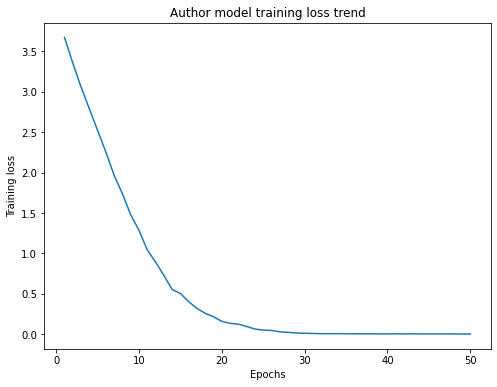

In [23]:
orig_train_loss_epoch = range(1, 51)
orig_train_loss = [3.673,3.357,3.059,2.790,2.522,2.254,1.965,1.737,1.476,1.285,1.041,0.893,0.727,0.552,0.503,0.401,0.318,0.257,0.215,0.158,0.134,0.124,0.095,0.063,0.050,0.046,0.029,0.022,0.014,0.011,0.008,0.006,0.006,0.006,0.005,0.005,0.004,0.004,0.003,0.003,0.004,0.003,0.004,0.003,0.003,0.003,0.003,0.002,0.002,0.002]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(orig_train_loss_epoch, orig_train_loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Training loss')
ax.set_title('Author model training loss trend')

In [10]:
train_loss, train_acc, test_loss, test_acc = aux
print(f'Train accuracy: {train_acc:.3}')
print(f'Test accuracy: {test_acc:.3}')

Train accuracy: 1.0
Test accuracy: 0.162


In [11]:
per_instance_loss = np.array(log_loss(true_y, pred_y))
pred_membership = yeom_membership_inference(per_instance_loss, membership, train_loss)

----------YEOM'S MEMBERSHIP INFERENCE----------

TP: 7198     FP: 557     FN: 2802     TN: 9443
PPV: 0.9282
Advantage: 0.6641


PPV = Precision

Advantage = TPR - FPR


Accuracy of membership model: 0.832
Area under ROC curve: 0.953



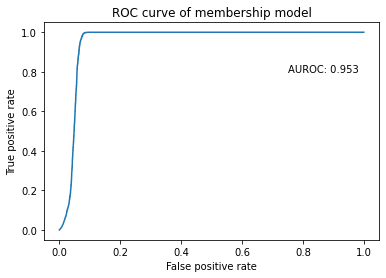

In [12]:
fpr, tpr, threshold = roc_curve(membership, -per_instance_loss, pos_label=1)
auroc = auc(fpr, tpr)

print(f'\nAccuracy of membership model: {accuracy_score(membership, pred_membership):.3}')
print(f'Area under ROC curve: {auroc:.3}\n')

plt.plot(fpr, tpr)
plt.annotate(f'AUROC: {auroc:.3}', (0.75, 0.8))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
_ = plt.title('ROC curve of membership model')

In [30]:
orig_eval = {
    'Accuracy': 0.832,
    'Precision': 0.923,
    'Advantage': 0.6641,
    'AUROC': 0.953
}
pd.DataFrame(data=orig_eval, index=['Author model'])

,Accuracy,Precision,Advantage,AUROC
Author model,0.832,0.923,0.6641,0.953


## Non private robust target model architecture

In [13]:
robust_args = Args()
robust_args.target_model = 'robust_nn'
robust_args.target_epochs = 70
robust_args.target_learning_rate = 0.001

In [14]:
pred_y, membership, test_classes, classifier, aux = train_target_model(
        args=robust_args,
        dataset=dataset,
        epochs=robust_args.target_epochs,
        batch_size=robust_args.target_batch_size,
        learning_rate=robust_args.target_learning_rate,
        clipping_threshold=robust_args.target_clipping_threshold,
        n_hidden=robust_args.target_n_hidden,
        l2_ratio=robust_args.target_l2_ratio,
        model=robust_args.target_model,
        privacy=robust_args.target_privacy,
        dp=robust_args.target_dp,
        epsilon=robust_args.target_epsilon,
        delta=robust_args.target_delta,
        save=robust_args.save_model
)

Using model robust_nn
Train loss after 1 epochs is: 4.578
Train loss after 2 epochs is: 4.490
Train loss after 3 epochs is: 4.283
Train loss after 4 epochs is: 4.085
Train loss after 5 epochs is: 3.974
Train loss after 6 epochs is: 3.910
Train loss after 7 epochs is: 3.867
Train loss after 8 epochs is: 3.830
Train loss after 9 epochs is: 3.797
Train loss after 10 epochs is: 3.770
Train loss after 11 epochs is: 3.744
Train loss after 12 epochs is: 3.721
Train loss after 13 epochs is: 3.701
Train loss after 14 epochs is: 3.684
Train loss after 15 epochs is: 3.666
Train loss after 16 epochs is: 3.652
Train loss after 17 epochs is: 3.636
Train loss after 18 epochs is: 3.622
Train loss after 19 epochs is: 3.610
Train loss after 20 epochs is: 3.599
Train loss after 21 epochs is: 3.586
Train loss after 22 epochs is: 3.576
Train loss after 23 epochs is: 3.566
Train loss after 24 epochs is: 3.554
Train loss after 25 epochs is: 3.544
Train loss after 26 epochs is: 3.536
Train loss after 27 epoch

(0.0, 4.8)

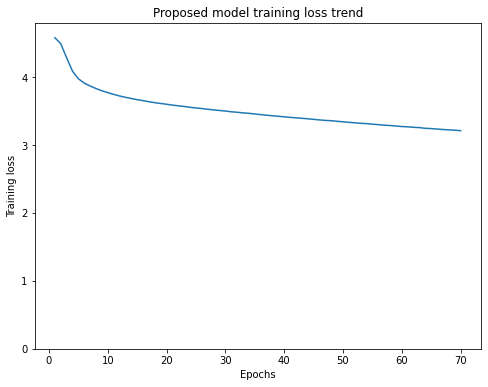

In [36]:
prop_train_loss_epoch = range(1, 71)
prop_train_loss = [4.578,4.490,4.283,4.085,3.974,3.910,3.867,3.830,3.797,3.770,3.744,3.721,3.701,3.684,3.666,3.652,3.636,3.622,3.610,3.599,3.586,3.576,3.566,3.554,3.544,3.536,3.525,3.516,3.507,3.499,3.488,3.481,3.472,3.465,3.456,3.446,3.438,3.429,3.422,3.414,3.406,3.399,3.392,3.385,3.377,3.368,3.361,3.357,3.348,3.341,3.333,3.326,3.318,3.314,3.306,3.299,3.291,3.286,3.279,3.271,3.267,3.260,3.255,3.245,3.241,3.234,3.227,3.222,3.217,3.210,]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(prop_train_loss_epoch, prop_train_loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Training loss')
ax.set_title('Proposed model training loss trend')
ax.set_ylim(0, 4.8)

In [37]:
train_loss, train_acc, test_loss, test_acc = aux
print(f'Train accuracy: {train_acc:.3}')
print(f'Test accuracy: {test_acc:.3}')

Train accuracy: 0.227
Test accuracy: 0.172


In [38]:
per_instance_loss = np.array(log_loss(true_y, pred_y))
pred_membership = yeom_membership_inference(per_instance_loss, membership, train_loss)

----------YEOM'S MEMBERSHIP INFERENCE----------

TP: 5093     FP: 4173     FN: 4907     TN: 5827
PPV: 0.5496
Advantage: 0.0920



Accuracy of membership model: 0.546
Area under ROC curve: 0.569



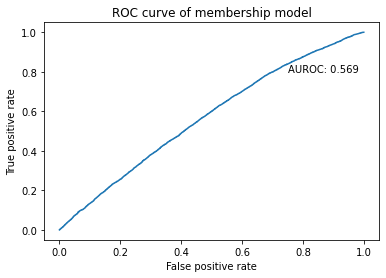

In [39]:
fpr, tpr, threshold = roc_curve(membership, -per_instance_loss, pos_label=1)
auroc = auc(fpr, tpr)

print(f'\nAccuracy of membership model: {accuracy_score(membership, pred_membership):.3}')
print(f'Area under ROC curve: {auroc:.3}\n')

plt.plot(fpr, tpr)
plt.annotate(f'AUROC: {auroc:.3}', (0.75, 0.8))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
_ = plt.title('ROC curve of membership model')

In [42]:
orig_eval = {
    'Accuracy': 0.546,
    'Precision': 0.5496,
    'Advantage': 0.092,
    'AUROC': 0.569
}
pd.DataFrame(data=orig_eval, index=['Proposed model'])

,Accuracy,Precision,Advantage,AUROC
Proposed model,0.546,0.5496,0.092,0.569
